In [1]:
%%bash
source ~/setup.sh

no change     /apps/conda/miniforge3/25.3.0/condabin/conda
no change     /apps/conda/miniforge3/25.3.0/bin/conda
no change     /apps/conda/miniforge3/25.3.0/bin/conda-env
no change     /apps/conda/miniforge3/25.3.0/bin/activate
no change     /apps/conda/miniforge3/25.3.0/bin/deactivate
no change     /apps/conda/miniforge3/25.3.0/etc/profile.d/conda.sh
no change     /apps/conda/miniforge3/25.3.0/etc/fish/conf.d/conda.fish
no change     /apps/conda/miniforge3/25.3.0/shell/condabin/Conda.psm1
no change     /apps/conda/miniforge3/25.3.0/shell/condabin/conda-hook.ps1
no change     /apps/conda/miniforge3/25.3.0/lib/python3.12/site-packages/xontrib/conda.xsh
no change     /apps/conda/miniforge3/25.3.0/etc/profile.d/conda.csh
no change     /home1/snehansh/.bashrc
No action taken.
✅ srj_test environment is now active with htop, conda, gcc, and cuda loaded!


In [2]:
%%bash
nvidia-smi

Sun Oct  5 18:09:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:81:00.0 Off |                    0 |
| N/A   35C    P0             46W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [4]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")
if cuda:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if cuda:
    torch.cuda.manual_seed(42)

CUDA Available? True
GPU: NVIDIA A100 80GB PCIe


In [5]:
class Cutout:
    """
    Cutout augmentation with probability control
    
    Args:
        n_holes: number of square masks
        length: size of square mask
        p: probability of applying cutout (NEW!)
    """
    def __init__(self, n_holes=1, length=16, p=0.5):
        self.n_holes = n_holes
        self.length = length
        self.p = p  # Probability of applying

    def __call__(self, img):
        # Randomly decide: apply or skip?
        if np.random.rand() > self.p:
            return img  # SKIP cutout for this image!
        
        # Apply cutout to this image
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

In [6]:
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

train_transforms = transforms.Compose([
    # RandomResizedCrop: Applied to 80% of images
    # (For 20% of images, use regular RandomCrop instead)
    transforms.RandomChoice([
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # 80% - zoom effect
        transforms.RandomCrop(32, padding=4),  # 20% - no zoom
    ], p=[0.8, 0.2]),
    
    # RandomHorizontalFlip: Applied to 50% of images (already optional!)
    transforms.RandomHorizontalFlip(p=0.5),
    
    # AutoAugment: Applied to 70% of images
    transforms.RandomApply([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10)
    ], p=0.7),
    
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
    
    # Cutout: Applied to 50% of images
    Cutout(n_holes=1, length=16, p=0.5),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

In [7]:
train_data = datasets.CIFAR100('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR100('../data', train=False, download=True, transform=test_transforms)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 50000
Test samples: 10000


In [8]:
batch_size = 2048

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 16, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **{**kwargs, 'shuffle': False})

print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(train_loader)}")


Batch size: 2048
Batches per epoch: 25


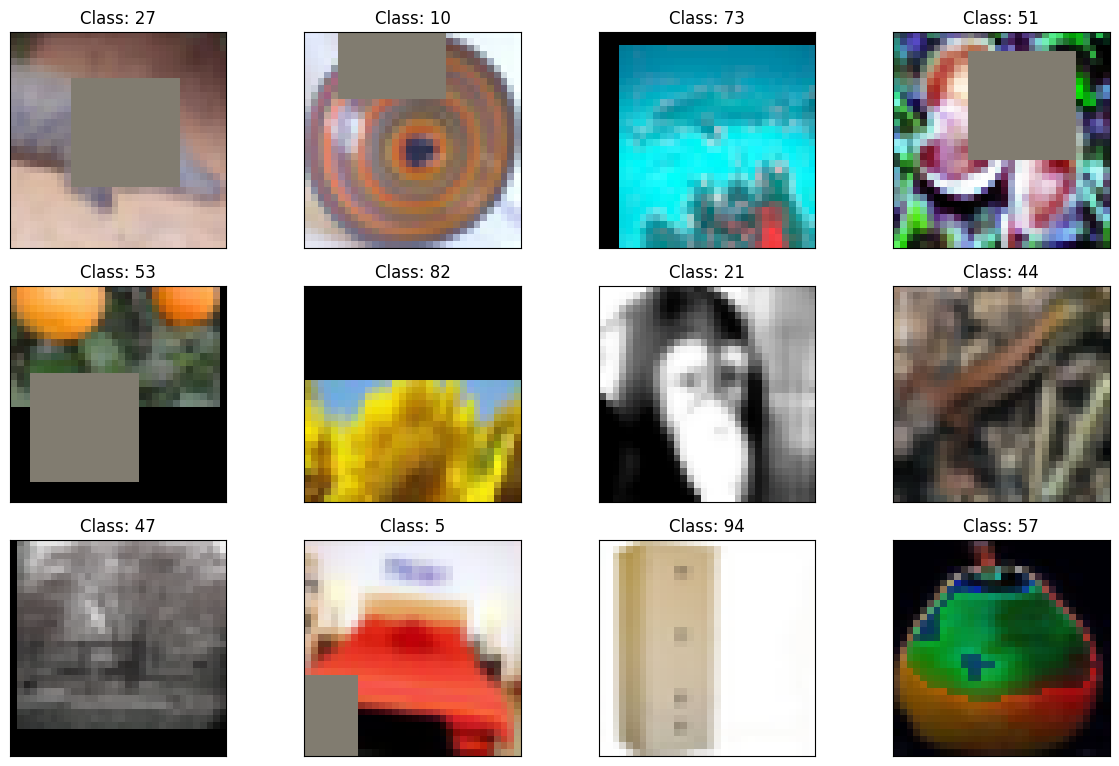

In [9]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    img = batch_data[i]
    img = img * torch.tensor(cifar100_std).view(3, 1, 1) + torch.tensor(cifar100_mean).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Class: {batch_label[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.show()

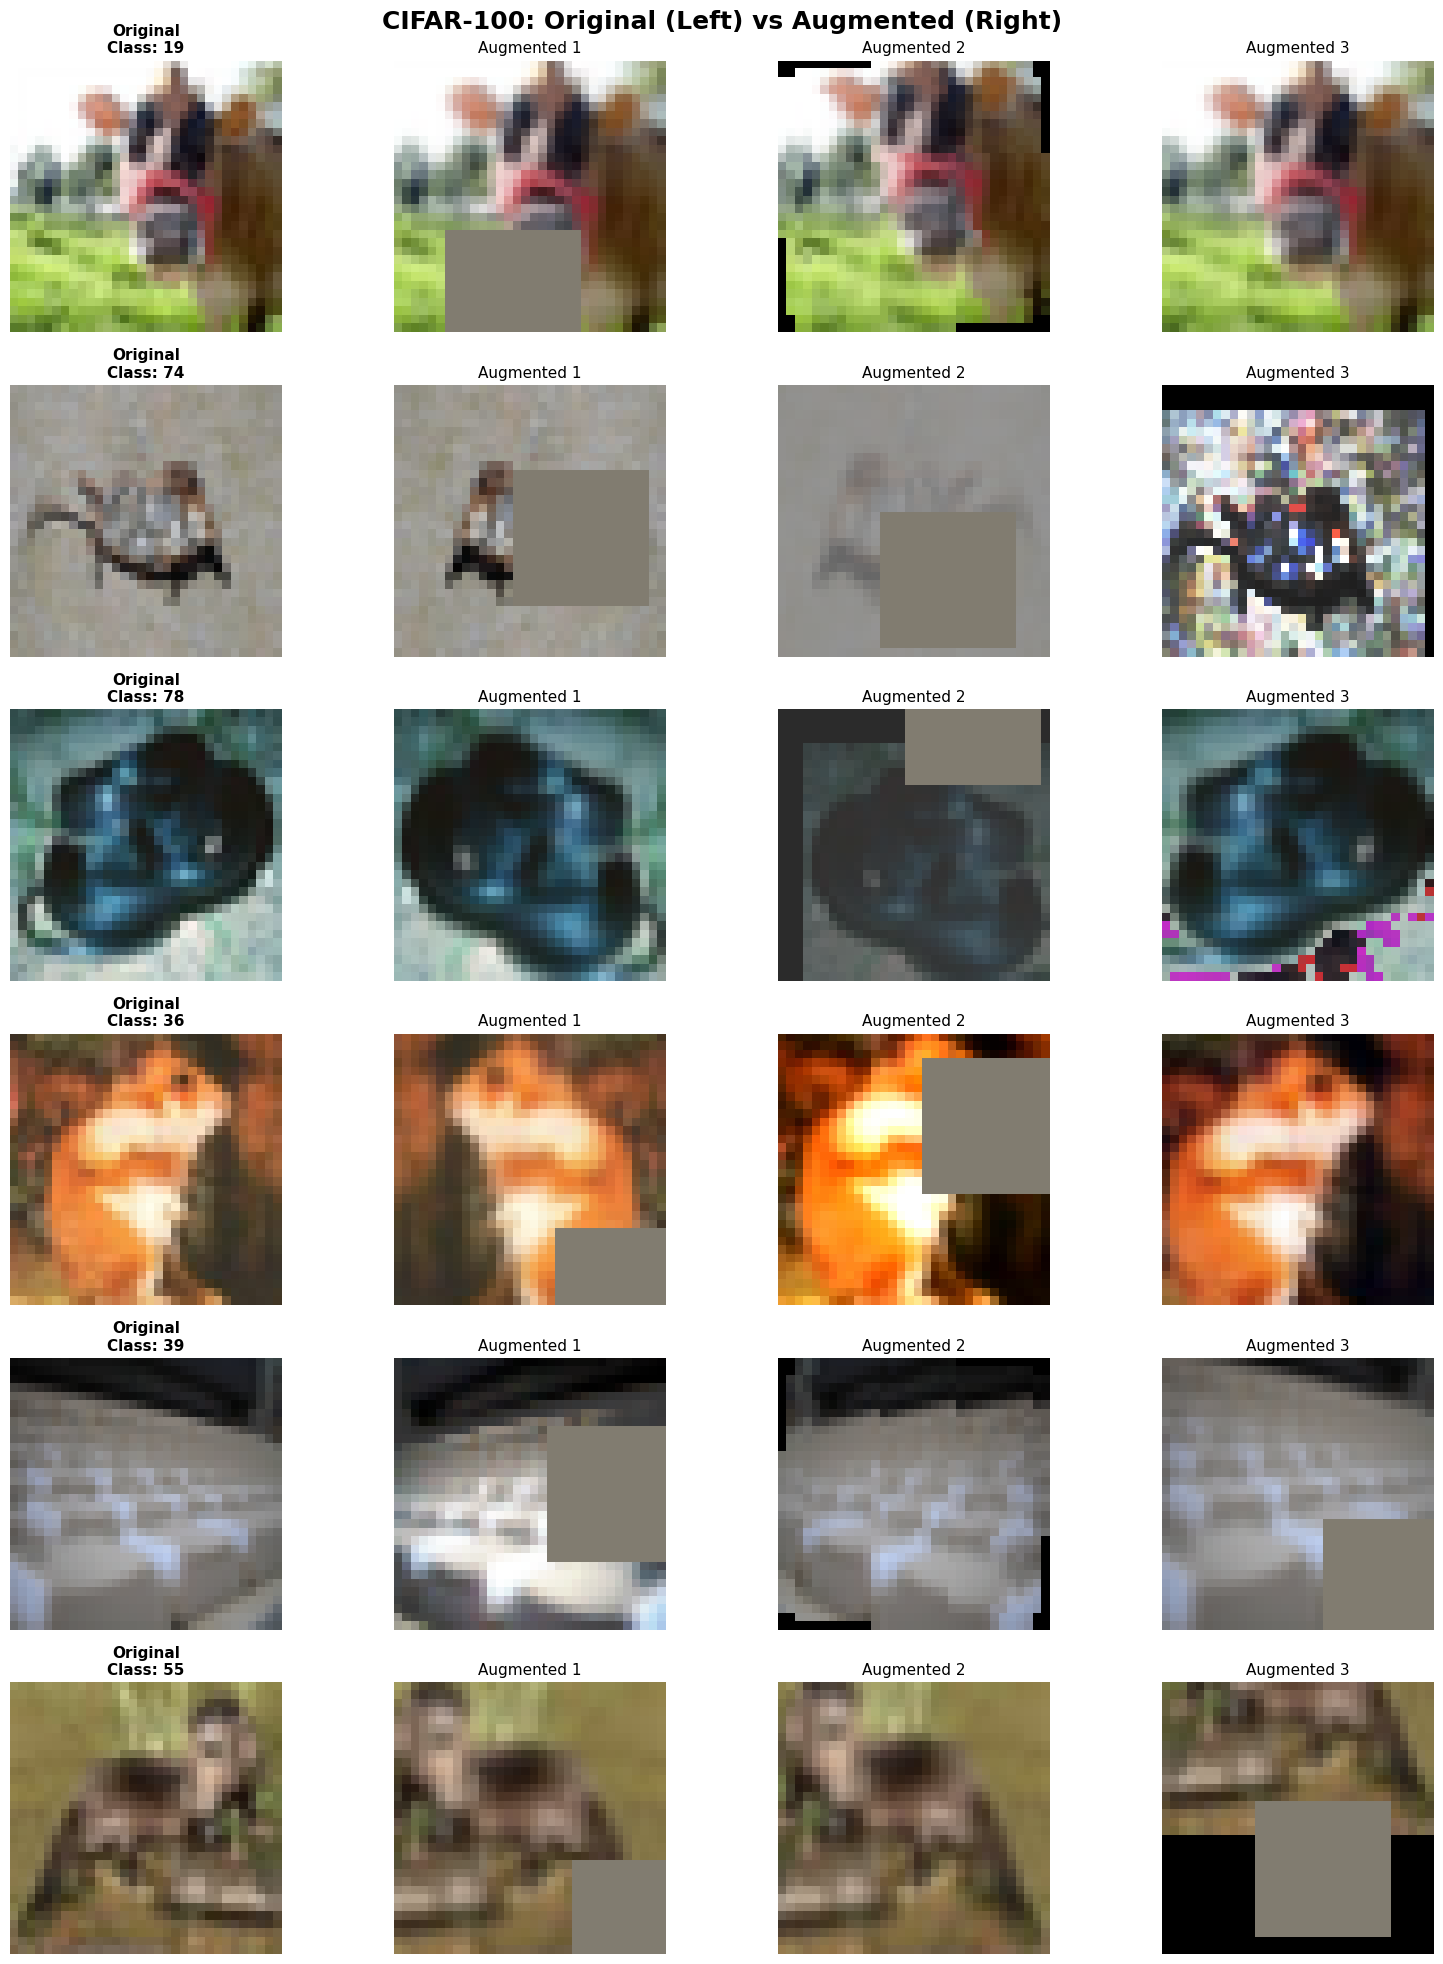


✓ Left column: Original CIFAR-100 images
✓ Right 3 columns: Same images with different random augmentations

Notice:
  - Some have cutout (black square), some don't
  - Some are zoomed, some aren't
  - Some are flipped, some aren't
  - Different colors/brightness due to AutoAugment


In [10]:
raw_data = datasets.CIFAR100('../data', train=True, download=False, transform=None)
aug_data = datasets.CIFAR100('../data', train=True, download=False, transform=train_transforms)

fig, axes = plt.subplots(6, 4, figsize=(16, 20))
fig.suptitle("CIFAR-100: Original (Left) vs Augmented (Right)", fontsize=18, fontweight='bold')

# Show 6 images × 2 columns (original + augmented)
for row in range(6):
    idx = row * 20  # Sample different images
    
    # Original image (left)
    img_original, label = raw_data[idx]
    axes[row, 0].imshow(img_original)
    axes[row, 0].set_title(f"Original\nClass: {label}", fontsize=11, fontweight='bold')
    axes[row, 0].axis('off')
    
    # 3 different augmented versions (right columns)
    for col in range(1, 4):
        img_aug, _ = aug_data[idx]  # Same index, different augmentation!
        
        # Denormalize for visualization
        img_aug = img_aug * torch.tensor(cifar100_std).view(3, 1, 1) + torch.tensor(cifar100_mean).view(3, 1, 1)
        img_aug = img_aug.permute(1, 2, 0).numpy()
        img_aug = np.clip(img_aug, 0, 1)
        
        axes[row, col].imshow(img_aug)
        axes[row, col].set_title(f"Augmented {col}", fontsize=11)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Left column: Original CIFAR-100 images")
print("✓ Right 3 columns: Same images with different random augmentations")
print("\nNotice:")
print("  - Some have cutout (black square), some don't")
print("  - Some are zoomed, some aren't")
print("  - Some are flipped, some aren't")
print("  - Different colors/brightness due to AutoAugment")

In [11]:
class Bottleneck(nn.Module):
    """
    Bottleneck block for ResNet-50
    
    Structure: 1×1 conv → 3×3 conv → 1×1 conv (with residual connection)
    
    Input channels: in_planes
    Output channels: planes × 4
    """
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        # 1×1 conv: reduce channels
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        # 3×3 conv: spatial processing
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # 1×1 conv: expand channels by 4×
        self.conv3 = nn.Conv2d(planes, self.expansion * planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        # Shortcut connection (identity or projection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)  # Add residual
        out = F.relu(out)
        return out


class ResNet50_CIFAR(nn.Module):
    """
    ResNet-50 adapted for CIFAR-100 (32×32 images)
    
    Architecture: [3, 4, 6, 3] Bottleneck blocks = 50 layers total
    
    Layer configuration:
    - layer1: 3 blocks, 64 channels, stride=1  (32×32 spatial size)
    - layer2: 4 blocks, 128 channels, stride=2 (16×16 spatial size)
    - layer3: 6 blocks, 256 channels, stride=2 (8×8 spatial size)
    - layer4: 3 blocks, 512 channels, stride=2 (4×4 spatial size)
    
    Total parameters: ~23M
    """
    def __init__(self, num_classes=100):
        super(ResNet50_CIFAR, self).__init__()
        self.in_planes = 64

        # Initial conv: 3×3, stride 1 (CIFAR-specific, NOT ImageNet style)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 4 stages with Bottleneck blocks
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        # Global average pooling + classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        """
        Create a layer with multiple Bottleneck blocks
        
        Args:
            planes: base channel count
            num_blocks: number of blocks in this layer
            stride: stride for first block (rest use stride=1)
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_planes, planes, stride))
            self.in_planes = planes * Bottleneck.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass
        
        Input: [batch_size, 3, 32, 32]
        Output: [batch_size, 100]
        """
        out = F.relu(self.bn1(self.conv1(x)))  # [B, 64, 32, 32]
        out = self.layer1(out)                  # [B, 256, 32, 32]
        out = self.layer2(out)                  # [B, 512, 16, 16]
        out = self.layer3(out)                  # [B, 1024, 8, 8]
        out = self.layer4(out)                  # [B, 2048, 4, 4]
        out = self.avgpool(out)                 # [B, 2048, 1, 1]
        out = out.view(out.size(0), -1)        # [B, 2048]
        out = self.fc(out)                      # [B, 100]
        return out

In [12]:
try:
    from torchsummary import summary
    model = ResNet50_CIFAR(num_classes=100).to(device)
    print(f"\nModel: ResNet-50 for CIFAR-100")
    summary(model, input_size=(3, 32, 32))
except:
    model = ResNet50_CIFAR(num_classes=100).to(device)
    print(f"\nModel: ResNet-50 for CIFAR-100")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")


Model: ResNet-50 for CIFAR-100
Parameters: 23.71M


In [13]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Label Smoothing: prevents overconfident predictions
    
    Instead of hard labels [0, 0, 1, 0, ...], use soft labels:
    - True class: 0.9
    - Other 99 classes: 0.001 each
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [14]:
def mixup_data(x, y, alpha=1.0):
    """
    Mixup: trains on convex combinations of pairs
    
    x_mixed = λ × x_i + (1-λ) × x_j
    y_mixed = λ × y_i + (1-λ) × y_j
    
    where λ ~ Beta(alpha, alpha)
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [15]:
class WarmupCosineLR(optim.lr_scheduler._LRScheduler):
    """
    Learning rate schedule: linear warmup + cosine annealing
    
    Phase 1: Linear warmup (epochs 0-5)
    - LR increases from 0 to base_lr
    
    Phase 2: Cosine annealing (epochs 5-200)
    - LR decreases following cosine curve from base_lr to min_lr
    """
    def __init__(self, optimizer, warmup_epochs, max_epochs, 
                 warmup_start_lr=1e-5, min_lr=1e-6, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.warmup_start_lr = warmup_start_lr
        self.min_lr = min_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            alpha = self.last_epoch / self.warmup_epochs
            return [self.warmup_start_lr + alpha * (base_lr - self.warmup_start_lr)
                   for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            return [self.min_lr + (base_lr - self.min_lr) * 0.5 * 
                   (1 + np.cos(np.pi * progress))
                   for base_lr in self.base_lrs]


In [16]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []

In [17]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, scaler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Apply mixup 50% of the time
        if np.random.rand() < 0.5:
            data, targets_a, targets_b, lam = mixup_data(data, target, alpha=0.2)
            
            with autocast():
                pred = model(data)
                loss = mixup_criterion(criterion, pred, targets_a, targets_b, lam)
        else:
            with autocast():
                pred = model(data)
                loss = criterion(pred, target)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Track metrics
        train_loss += loss.item()
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        
        pbar.set_description(desc=f'Epoch {epoch} [TRAIN]: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    
    test_loss = 0
    correct = 0
    correct_top5 = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()
            
            # Top-1 accuracy
            correct += GetCorrectPredCount(output, target)
            
            # Top-5 accuracy
            _, pred_top5 = output.topk(5, 1, True, True)
            pred_top5 = pred_top5.t()
            correct_top5 += pred_top5.eq(target.view(1, -1).expand_as(pred_top5)).sum().item()
    
    test_loss /= len(test_loader)
    top1_accuracy = 100. * correct / len(test_loader.dataset)
    top5_accuracy = 100. * correct_top5 / len(test_loader.dataset)
    
    test_acc.append(top1_accuracy)
    test_losses.append(test_loss)
    
    print(f'\nEpoch {epoch} [TEST]: Loss: {test_loss:.4f}, Top-1: {top1_accuracy:.2f}%, Top-5: {top5_accuracy:.2f}%\n')


In [18]:
num_epochs = 200
initial_lr = 0.8  
momentum = 0.9
weight_decay = 5e-4

model = ResNet50_CIFAR(num_classes=100).to(device)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
scheduler = WarmupCosineLR(optimizer, warmup_epochs=5, max_epochs=num_epochs)
scaler = GradScaler()

os.makedirs('checkpoints', exist_ok=True)

print(f'\n{"="*60}')
print(f'Training ResNet-50 on CIFAR-100')
print(f'Target: 73%+ Top-1 Accuracy')
print(f'GPU: {torch.cuda.get_device_name(0) if cuda else "CPU"}')
print(f'Batch Size: {batch_size} | Epochs: {num_epochs} | Initial LR: {initial_lr}')
print(f'{"="*60}\n')

best_acc = 0.0
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    print(f'\n{"="*60}')
    print(f'Epoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')
    print(f'{"="*60}')
    
    train(model, device, train_loader, optimizer, criterion, scaler, epoch)
    test(model, device, test_loader, criterion, epoch)
    
    scheduler.step()
    
    if test_acc[-1] > best_acc:
        best_acc = test_acc[-1]
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, 'checkpoints/resnet50_cifar100_best.pth')
        print(f'✓ Best model saved! Accuracy: {best_acc:.2f}%')
    
    if epoch % 20 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, f'checkpoints/resnet50_cifar100_epoch_{epoch}.pth')

total_time = time.time() - start_time
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Total Time: {total_time/3600:.2f} hours')
print(f'Best Top-1 Accuracy: {best_acc:.2f}%')
print(f'{"="*60}')

/tmp/SLURM_3957661/ipykernel_892346/1785693227.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Model Parameters: 23.71M

Training ResNet-50 on CIFAR-100
Target: 73%+ Top-1 Accuracy
GPU: NVIDIA A100 80GB PCIe
Batch Size: 2048 | Epochs: 200 | Initial LR: 0.8


Epoch 1/200 | LR: 0.000010


  0%|          | 0/25 [00:00<?, ?it/s]/tmp/SLURM_3957661/ipykernel_892346/1522417471.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [TRAIN]: Loss=4.7595 Batch_id=0 Accuracy=1.12%:   4%|▍         | 1/25 [00:02<00:59,  2.49s/it]/tmp/SLURM_3957661/ipykernel_892346/1522417471.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [TRAIN]: Loss=4.7692 Batch_id=24 Accuracy=1.05%: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]



Epoch 1 [TEST]: Loss: 4.6404, Top-1: 1.00%, Top-5: 4.78%

✓ Best model saved! Accuracy: 1.00%

Epoch 2/200 | LR: 0.160008


Epoch 2 [TRAIN]: Loss=4.8757 Batch_id=24 Accuracy=1.03%: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]



Epoch 2 [TEST]: Loss: 440977.2750, Top-1: 0.94%, Top-5: 4.55%


Epoch 3/200 | LR: 0.320006


Epoch 3 [TRAIN]: Loss=4.6520 Batch_id=24 Accuracy=1.20%: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]



Epoch 3 [TEST]: Loss: 6.6582, Top-1: 1.14%, Top-5: 5.99%

✓ Best model saved! Accuracy: 1.14%

Epoch 4/200 | LR: 0.480004


Epoch 4 [TRAIN]: Loss=4.6471 Batch_id=24 Accuracy=1.24%: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]



Epoch 4 [TEST]: Loss: 4.6051, Top-1: 1.02%, Top-5: 5.05%


Epoch 5/200 | LR: 0.640002


Epoch 5 [TRAIN]: Loss=4.5958 Batch_id=24 Accuracy=1.29%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 5 [TEST]: Loss: 4.6046, Top-1: 1.00%, Top-5: 5.14%


Epoch 6/200 | LR: 0.800000


Epoch 6 [TRAIN]: Loss=4.5797 Batch_id=24 Accuracy=1.36%: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]



Epoch 6 [TEST]: Loss: 4.6026, Top-1: 1.07%, Top-5: 5.29%


Epoch 7/200 | LR: 0.799948


Epoch 7 [TRAIN]: Loss=4.5758 Batch_id=24 Accuracy=1.29%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 7 [TEST]: Loss: 4.5888, Top-1: 1.59%, Top-5: 7.43%

✓ Best model saved! Accuracy: 1.59%

Epoch 8/200 | LR: 0.799792


Epoch 8 [TRAIN]: Loss=4.5879 Batch_id=24 Accuracy=1.42%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 8 [TEST]: Loss: 4.5691, Top-1: 1.76%, Top-5: 8.53%

✓ Best model saved! Accuracy: 1.76%

Epoch 9/200 | LR: 0.799533


Epoch 9 [TRAIN]: Loss=4.5606 Batch_id=24 Accuracy=1.60%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 9 [TEST]: Loss: 4.5628, Top-1: 1.63%, Top-5: 8.28%


Epoch 10/200 | LR: 0.799170


Epoch 10 [TRAIN]: Loss=4.5631 Batch_id=24 Accuracy=1.69%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 10 [TEST]: Loss: 4.5704, Top-1: 1.67%, Top-5: 6.99%


Epoch 11/200 | LR: 0.798703


Epoch 11 [TRAIN]: Loss=4.5062 Batch_id=24 Accuracy=1.93%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 11 [TEST]: Loss: 4.5260, Top-1: 1.20%, Top-5: 6.94%


Epoch 12/200 | LR: 0.798133


Epoch 12 [TRAIN]: Loss=4.5649 Batch_id=24 Accuracy=2.06%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 12 [TEST]: Loss: 4.4290, Top-1: 2.78%, Top-5: 12.80%

✓ Best model saved! Accuracy: 2.78%

Epoch 13/200 | LR: 0.797459


Epoch 13 [TRAIN]: Loss=4.5026 Batch_id=24 Accuracy=2.90%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 13 [TEST]: Loss: 4.4432, Top-1: 3.00%, Top-5: 12.52%

✓ Best model saved! Accuracy: 3.00%

Epoch 14/200 | LR: 0.796682


Epoch 14 [TRAIN]: Loss=4.2933 Batch_id=24 Accuracy=3.33%: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]



Epoch 14 [TEST]: Loss: 4.4070, Top-1: 3.41%, Top-5: 14.19%

✓ Best model saved! Accuracy: 3.41%

Epoch 15/200 | LR: 0.795803


Epoch 15 [TRAIN]: Loss=4.3347 Batch_id=24 Accuracy=3.45%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 15 [TEST]: Loss: 4.4368, Top-1: 3.46%, Top-5: 13.31%

✓ Best model saved! Accuracy: 3.46%

Epoch 16/200 | LR: 0.794820


Epoch 16 [TRAIN]: Loss=4.4570 Batch_id=24 Accuracy=4.49%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 16 [TEST]: Loss: 4.3651, Top-1: 4.53%, Top-5: 16.45%

✓ Best model saved! Accuracy: 4.53%

Epoch 17/200 | LR: 0.793735


Epoch 17 [TRAIN]: Loss=4.1138 Batch_id=24 Accuracy=5.45%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 17 [TEST]: Loss: 4.1526, Top-1: 7.10%, Top-5: 24.94%

✓ Best model saved! Accuracy: 7.10%

Epoch 18/200 | LR: 0.792548


Epoch 18 [TRAIN]: Loss=4.0936 Batch_id=24 Accuracy=6.78%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 18 [TEST]: Loss: 4.2074, Top-1: 6.08%, Top-5: 21.80%


Epoch 19/200 | LR: 0.791259


Epoch 19 [TRAIN]: Loss=4.0811 Batch_id=24 Accuracy=7.66%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 19 [TEST]: Loss: 3.9539, Top-1: 9.44%, Top-5: 32.06%

✓ Best model saved! Accuracy: 9.44%

Epoch 20/200 | LR: 0.789868


Epoch 20 [TRAIN]: Loss=3.9875 Batch_id=24 Accuracy=8.24%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 20 [TEST]: Loss: 3.8907, Top-1: 12.21%, Top-5: 36.03%

✓ Best model saved! Accuracy: 12.21%

Epoch 21/200 | LR: 0.788377


Epoch 21 [TRAIN]: Loss=3.8833 Batch_id=24 Accuracy=8.81%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 21 [TEST]: Loss: 3.8100, Top-1: 14.74%, Top-5: 38.79%

✓ Best model saved! Accuracy: 14.74%

Epoch 22/200 | LR: 0.786784


Epoch 22 [TRAIN]: Loss=4.2415 Batch_id=24 Accuracy=10.66%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 22 [TEST]: Loss: 3.8842, Top-1: 12.33%, Top-5: 35.95%


Epoch 23/200 | LR: 0.785091


Epoch 23 [TRAIN]: Loss=3.6551 Batch_id=24 Accuracy=11.22%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 23 [TEST]: Loss: 3.7574, Top-1: 15.64%, Top-5: 41.12%

✓ Best model saved! Accuracy: 15.64%

Epoch 24/200 | LR: 0.783298


Epoch 24 [TRAIN]: Loss=3.4700 Batch_id=24 Accuracy=14.40%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 24 [TEST]: Loss: 3.6752, Top-1: 17.65%, Top-5: 43.60%

✓ Best model saved! Accuracy: 17.65%

Epoch 25/200 | LR: 0.781406


Epoch 25 [TRAIN]: Loss=3.3674 Batch_id=24 Accuracy=19.21%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 25 [TEST]: Loss: 3.5882, Top-1: 19.00%, Top-5: 47.58%

✓ Best model saved! Accuracy: 19.00%

Epoch 26/200 | LR: 0.779415


Epoch 26 [TRAIN]: Loss=3.2560 Batch_id=24 Accuracy=18.65%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 26 [TEST]: Loss: 3.5220, Top-1: 22.75%, Top-5: 51.19%

✓ Best model saved! Accuracy: 22.75%

Epoch 27/200 | LR: 0.777325


Epoch 27 [TRAIN]: Loss=3.1599 Batch_id=24 Accuracy=18.82%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 27 [TEST]: Loss: 3.9235, Top-1: 18.80%, Top-5: 46.55%


Epoch 28/200 | LR: 0.775137


Epoch 28 [TRAIN]: Loss=3.0373 Batch_id=24 Accuracy=21.26%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 28 [TEST]: Loss: 3.2130, Top-1: 27.91%, Top-5: 58.66%

✓ Best model saved! Accuracy: 27.91%

Epoch 29/200 | LR: 0.772852


Epoch 29 [TRAIN]: Loss=2.9146 Batch_id=24 Accuracy=25.24%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 29 [TEST]: Loss: 3.3568, Top-1: 26.58%, Top-5: 55.78%


Epoch 30/200 | LR: 0.770470


Epoch 30 [TRAIN]: Loss=2.9473 Batch_id=24 Accuracy=27.79%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 30 [TEST]: Loss: 3.1826, Top-1: 29.79%, Top-5: 59.48%

✓ Best model saved! Accuracy: 29.79%

Epoch 31/200 | LR: 0.767992


Epoch 31 [TRAIN]: Loss=2.8989 Batch_id=24 Accuracy=26.63%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 31 [TEST]: Loss: 3.3520, Top-1: 27.76%, Top-5: 55.91%


Epoch 32/200 | LR: 0.765418


Epoch 32 [TRAIN]: Loss=2.8610 Batch_id=24 Accuracy=29.57%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 32 [TEST]: Loss: 3.5430, Top-1: 22.55%, Top-5: 52.36%


Epoch 33/200 | LR: 0.762750


Epoch 33 [TRAIN]: Loss=2.8292 Batch_id=24 Accuracy=22.02%: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]



Epoch 33 [TEST]: Loss: 2.8468, Top-1: 38.10%, Top-5: 68.38%

✓ Best model saved! Accuracy: 38.10%

Epoch 34/200 | LR: 0.759987


Epoch 34 [TRAIN]: Loss=2.7553 Batch_id=24 Accuracy=31.28%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 34 [TEST]: Loss: 3.1430, Top-1: 32.08%, Top-5: 63.27%


Epoch 35/200 | LR: 0.757131


Epoch 35 [TRAIN]: Loss=3.0961 Batch_id=24 Accuracy=32.86%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 35 [TEST]: Loss: 2.7251, Top-1: 40.81%, Top-5: 72.94%

✓ Best model saved! Accuracy: 40.81%

Epoch 36/200 | LR: 0.754182


Epoch 36 [TRAIN]: Loss=2.6463 Batch_id=24 Accuracy=35.76%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 36 [TEST]: Loss: 3.1642, Top-1: 31.91%, Top-5: 61.80%


Epoch 37/200 | LR: 0.751142


Epoch 37 [TRAIN]: Loss=2.6116 Batch_id=24 Accuracy=33.08%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 37 [TEST]: Loss: 2.6479, Top-1: 42.34%, Top-5: 74.69%

✓ Best model saved! Accuracy: 42.34%

Epoch 38/200 | LR: 0.748010


Epoch 38 [TRAIN]: Loss=2.9430 Batch_id=24 Accuracy=30.78%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 38 [TEST]: Loss: 2.9104, Top-1: 37.94%, Top-5: 67.51%


Epoch 39/200 | LR: 0.744788


Epoch 39 [TRAIN]: Loss=2.9492 Batch_id=24 Accuracy=37.75%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 39 [TEST]: Loss: 2.8715, Top-1: 37.18%, Top-5: 69.96%


Epoch 40/200 | LR: 0.741476


Epoch 40 [TRAIN]: Loss=2.4100 Batch_id=24 Accuracy=29.01%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 40 [TEST]: Loss: 2.6707, Top-1: 42.13%, Top-5: 74.07%


Epoch 41/200 | LR: 0.738076


Epoch 41 [TRAIN]: Loss=2.7596 Batch_id=24 Accuracy=39.96%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 41 [TEST]: Loss: 2.6464, Top-1: 42.90%, Top-5: 74.47%

✓ Best model saved! Accuracy: 42.90%

Epoch 42/200 | LR: 0.734588


Epoch 42 [TRAIN]: Loss=2.3623 Batch_id=24 Accuracy=42.95%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 42 [TEST]: Loss: 2.6637, Top-1: 43.08%, Top-5: 73.99%

✓ Best model saved! Accuracy: 43.08%

Epoch 43/200 | LR: 0.731013


Epoch 43 [TRAIN]: Loss=2.3021 Batch_id=24 Accuracy=38.44%: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s]



Epoch 43 [TEST]: Loss: 2.7616, Top-1: 40.58%, Top-5: 72.28%


Epoch 44/200 | LR: 0.727353


Epoch 44 [TRAIN]: Loss=2.3704 Batch_id=24 Accuracy=34.30%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 44 [TEST]: Loss: 2.6843, Top-1: 43.29%, Top-5: 72.96%

✓ Best model saved! Accuracy: 43.29%

Epoch 45/200 | LR: 0.723607


Epoch 45 [TRAIN]: Loss=2.3918 Batch_id=24 Accuracy=41.64%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 45 [TEST]: Loss: 2.9710, Top-1: 37.23%, Top-5: 70.34%


Epoch 46/200 | LR: 0.719777


Epoch 46 [TRAIN]: Loss=2.2999 Batch_id=24 Accuracy=32.80%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 46 [TEST]: Loss: 2.3525, Top-1: 50.82%, Top-5: 81.51%

✓ Best model saved! Accuracy: 50.82%

Epoch 47/200 | LR: 0.715865


Epoch 47 [TRAIN]: Loss=2.3161 Batch_id=24 Accuracy=41.82%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 47 [TEST]: Loss: 2.5588, Top-1: 46.19%, Top-5: 75.79%


Epoch 48/200 | LR: 0.711870


Epoch 48 [TRAIN]: Loss=2.2697 Batch_id=24 Accuracy=42.08%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 48 [TEST]: Loss: 2.3497, Top-1: 51.09%, Top-5: 80.14%

✓ Best model saved! Accuracy: 51.09%

Epoch 49/200 | LR: 0.707794


Epoch 49 [TRAIN]: Loss=2.2540 Batch_id=24 Accuracy=39.36%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 49 [TEST]: Loss: 2.4380, Top-1: 49.14%, Top-5: 79.70%


Epoch 50/200 | LR: 0.703639


Epoch 50 [TRAIN]: Loss=2.0441 Batch_id=24 Accuracy=48.00%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 50 [TEST]: Loss: 2.4313, Top-1: 48.28%, Top-5: 80.27%


Epoch 51/200 | LR: 0.699404


Epoch 51 [TRAIN]: Loss=2.1157 Batch_id=24 Accuracy=42.20%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 51 [TEST]: Loss: 2.2892, Top-1: 52.55%, Top-5: 82.31%

✓ Best model saved! Accuracy: 52.55%

Epoch 52/200 | LR: 0.695092


Epoch 52 [TRAIN]: Loss=2.6207 Batch_id=24 Accuracy=39.54%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 52 [TEST]: Loss: 2.7446, Top-1: 43.65%, Top-5: 72.19%


Epoch 53/200 | LR: 0.690704


Epoch 53 [TRAIN]: Loss=2.2171 Batch_id=24 Accuracy=40.78%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 53 [TEST]: Loss: 2.6983, Top-1: 44.61%, Top-5: 74.24%


Epoch 54/200 | LR: 0.686240


Epoch 54 [TRAIN]: Loss=2.2752 Batch_id=24 Accuracy=39.78%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 54 [TEST]: Loss: 2.4500, Top-1: 49.08%, Top-5: 79.22%


Epoch 55/200 | LR: 0.681701


Epoch 55 [TRAIN]: Loss=2.5578 Batch_id=24 Accuracy=44.39%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 55 [TEST]: Loss: 2.4312, Top-1: 49.17%, Top-5: 79.74%


Epoch 56/200 | LR: 0.677090


Epoch 56 [TRAIN]: Loss=3.0488 Batch_id=24 Accuracy=37.06%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 56 [TEST]: Loss: 2.3589, Top-1: 51.30%, Top-5: 80.74%


Epoch 57/200 | LR: 0.672407


Epoch 57 [TRAIN]: Loss=2.0966 Batch_id=24 Accuracy=48.97%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 57 [TEST]: Loss: 2.5471, Top-1: 48.15%, Top-5: 78.09%


Epoch 58/200 | LR: 0.667652


Epoch 58 [TRAIN]: Loss=2.0089 Batch_id=24 Accuracy=41.92%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 58 [TEST]: Loss: 2.3829, Top-1: 50.64%, Top-5: 80.49%


Epoch 59/200 | LR: 0.662829


Epoch 59 [TRAIN]: Loss=2.1031 Batch_id=24 Accuracy=32.29%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 59 [TEST]: Loss: 2.2425, Top-1: 54.32%, Top-5: 83.44%

✓ Best model saved! Accuracy: 54.32%

Epoch 60/200 | LR: 0.657937


Epoch 60 [TRAIN]: Loss=2.0747 Batch_id=24 Accuracy=44.93%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 60 [TEST]: Loss: 2.4016, Top-1: 50.22%, Top-5: 79.42%


Epoch 61/200 | LR: 0.652978


Epoch 61 [TRAIN]: Loss=1.9967 Batch_id=24 Accuracy=40.99%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 61 [TEST]: Loss: 2.3959, Top-1: 49.80%, Top-5: 80.84%


Epoch 62/200 | LR: 0.647954


Epoch 62 [TRAIN]: Loss=2.0866 Batch_id=24 Accuracy=47.74%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 62 [TEST]: Loss: 2.1991, Top-1: 54.66%, Top-5: 84.30%

✓ Best model saved! Accuracy: 54.66%

Epoch 63/200 | LR: 0.642865


Epoch 63 [TRAIN]: Loss=2.1546 Batch_id=24 Accuracy=37.73%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 63 [TEST]: Loss: 2.4961, Top-1: 48.96%, Top-5: 80.35%


Epoch 64/200 | LR: 0.637713


Epoch 64 [TRAIN]: Loss=1.9670 Batch_id=24 Accuracy=45.70%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 64 [TEST]: Loss: 2.2493, Top-1: 53.58%, Top-5: 83.45%


Epoch 65/200 | LR: 0.632500


Epoch 65 [TRAIN]: Loss=1.8978 Batch_id=24 Accuracy=52.44%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 65 [TEST]: Loss: 2.2984, Top-1: 53.56%, Top-5: 82.31%


Epoch 66/200 | LR: 0.627226


Epoch 66 [TRAIN]: Loss=1.8974 Batch_id=24 Accuracy=54.02%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 66 [TEST]: Loss: 2.2939, Top-1: 53.31%, Top-5: 82.67%


Epoch 67/200 | LR: 0.621893


Epoch 67 [TRAIN]: Loss=2.4914 Batch_id=24 Accuracy=55.51%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 67 [TEST]: Loss: 2.2616, Top-1: 54.54%, Top-5: 83.02%


Epoch 68/200 | LR: 0.616503


Epoch 68 [TRAIN]: Loss=1.9177 Batch_id=24 Accuracy=39.59%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 68 [TEST]: Loss: 2.0981, Top-1: 58.77%, Top-5: 86.60%

✓ Best model saved! Accuracy: 58.77%

Epoch 69/200 | LR: 0.611056


Epoch 69 [TRAIN]: Loss=3.1894 Batch_id=24 Accuracy=40.61%: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]



Epoch 69 [TEST]: Loss: 2.4641, Top-1: 48.84%, Top-5: 80.69%


Epoch 70/200 | LR: 0.605555


Epoch 70 [TRAIN]: Loss=1.9072 Batch_id=24 Accuracy=48.70%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 70 [TEST]: Loss: 2.2075, Top-1: 55.16%, Top-5: 84.61%


Epoch 71/200 | LR: 0.600000


Epoch 71 [TRAIN]: Loss=3.4025 Batch_id=24 Accuracy=56.20%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 71 [TEST]: Loss: 2.2615, Top-1: 55.75%, Top-5: 82.87%


Epoch 72/200 | LR: 0.594394


Epoch 72 [TRAIN]: Loss=1.9373 Batch_id=24 Accuracy=45.30%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 72 [TEST]: Loss: 2.3682, Top-1: 51.71%, Top-5: 80.73%


Epoch 73/200 | LR: 0.588737


Epoch 73 [TRAIN]: Loss=1.9576 Batch_id=24 Accuracy=55.06%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 73 [TEST]: Loss: 2.0942, Top-1: 58.42%, Top-5: 86.18%


Epoch 74/200 | LR: 0.583030


Epoch 74 [TRAIN]: Loss=2.3723 Batch_id=24 Accuracy=51.82%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 74 [TEST]: Loss: 2.1593, Top-1: 57.33%, Top-5: 84.71%


Epoch 75/200 | LR: 0.577277


Epoch 75 [TRAIN]: Loss=1.8519 Batch_id=24 Accuracy=50.99%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 75 [TEST]: Loss: 2.0962, Top-1: 58.63%, Top-5: 86.45%


Epoch 76/200 | LR: 0.571477


Epoch 76 [TRAIN]: Loss=2.5447 Batch_id=24 Accuracy=49.95%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 76 [TEST]: Loss: 2.2433, Top-1: 55.83%, Top-5: 83.61%


Epoch 77/200 | LR: 0.565633


Epoch 77 [TRAIN]: Loss=1.9364 Batch_id=24 Accuracy=39.64%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 77 [TEST]: Loss: 2.2751, Top-1: 54.56%, Top-5: 82.08%


Epoch 78/200 | LR: 0.559746


Epoch 78 [TRAIN]: Loss=1.8745 Batch_id=24 Accuracy=57.88%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 78 [TEST]: Loss: 2.4305, Top-1: 49.82%, Top-5: 80.58%


Epoch 79/200 | LR: 0.553818


Epoch 79 [TRAIN]: Loss=1.8478 Batch_id=24 Accuracy=50.47%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 79 [TEST]: Loss: 2.2510, Top-1: 54.97%, Top-5: 83.13%


Epoch 80/200 | LR: 0.547849


Epoch 80 [TRAIN]: Loss=2.6160 Batch_id=24 Accuracy=57.01%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 80 [TEST]: Loss: 2.2668, Top-1: 54.38%, Top-5: 83.21%


Epoch 81/200 | LR: 0.541842


Epoch 81 [TRAIN]: Loss=1.8801 Batch_id=24 Accuracy=40.19%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 81 [TEST]: Loss: 2.3998, Top-1: 51.78%, Top-5: 80.15%


Epoch 82/200 | LR: 0.535799


Epoch 82 [TRAIN]: Loss=1.7730 Batch_id=24 Accuracy=42.22%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 82 [TEST]: Loss: 2.2568, Top-1: 54.86%, Top-5: 82.65%


Epoch 83/200 | LR: 0.529720


Epoch 83 [TRAIN]: Loss=3.6533 Batch_id=24 Accuracy=50.09%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 83 [TEST]: Loss: 2.3618, Top-1: 54.82%, Top-5: 81.93%


Epoch 84/200 | LR: 0.523607


Epoch 84 [TRAIN]: Loss=3.7688 Batch_id=24 Accuracy=47.89%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 84 [TEST]: Loss: 2.2438, Top-1: 55.47%, Top-5: 83.32%


Epoch 85/200 | LR: 0.517462


Epoch 85 [TRAIN]: Loss=1.7930 Batch_id=24 Accuracy=49.65%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 85 [TEST]: Loss: 2.2817, Top-1: 54.61%, Top-5: 82.19%


Epoch 86/200 | LR: 0.511287


Epoch 86 [TRAIN]: Loss=1.7514 Batch_id=24 Accuracy=52.96%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 86 [TEST]: Loss: 2.1277, Top-1: 57.10%, Top-5: 85.88%


Epoch 87/200 | LR: 0.505083


Epoch 87 [TRAIN]: Loss=1.8021 Batch_id=24 Accuracy=51.72%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 87 [TEST]: Loss: 2.0772, Top-1: 59.88%, Top-5: 85.89%

✓ Best model saved! Accuracy: 59.88%

Epoch 88/200 | LR: 0.498852


Epoch 88 [TRAIN]: Loss=1.7263 Batch_id=24 Accuracy=48.03%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 88 [TEST]: Loss: 2.0039, Top-1: 61.22%, Top-5: 88.37%

✓ Best model saved! Accuracy: 61.22%

Epoch 89/200 | LR: 0.492595


Epoch 89 [TRAIN]: Loss=1.8215 Batch_id=24 Accuracy=42.95%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 89 [TEST]: Loss: 1.9009, Top-1: 64.41%, Top-5: 88.68%

✓ Best model saved! Accuracy: 64.41%

Epoch 90/200 | LR: 0.486314


Epoch 90 [TRAIN]: Loss=1.7928 Batch_id=24 Accuracy=60.51%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 90 [TEST]: Loss: 2.1011, Top-1: 58.99%, Top-5: 86.24%


Epoch 91/200 | LR: 0.480011


Epoch 91 [TRAIN]: Loss=1.6408 Batch_id=24 Accuracy=51.43%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 91 [TEST]: Loss: 2.1701, Top-1: 57.51%, Top-5: 85.38%


Epoch 92/200 | LR: 0.473687


Epoch 92 [TRAIN]: Loss=1.7276 Batch_id=24 Accuracy=47.33%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 92 [TEST]: Loss: 2.0688, Top-1: 59.48%, Top-5: 87.33%


Epoch 93/200 | LR: 0.467343


Epoch 93 [TRAIN]: Loss=1.7833 Batch_id=24 Accuracy=57.34%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 93 [TEST]: Loss: 2.2190, Top-1: 55.83%, Top-5: 83.66%


Epoch 94/200 | LR: 0.460982


Epoch 94 [TRAIN]: Loss=1.6843 Batch_id=24 Accuracy=53.69%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 94 [TEST]: Loss: 2.0807, Top-1: 60.14%, Top-5: 86.72%


Epoch 95/200 | LR: 0.454606


Epoch 95 [TRAIN]: Loss=1.8952 Batch_id=24 Accuracy=44.96%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 95 [TEST]: Loss: 2.2796, Top-1: 56.57%, Top-5: 82.98%


Epoch 96/200 | LR: 0.448215


Epoch 96 [TRAIN]: Loss=1.6869 Batch_id=24 Accuracy=50.22%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 96 [TEST]: Loss: 2.0000, Top-1: 61.63%, Top-5: 88.10%


Epoch 97/200 | LR: 0.441812


Epoch 97 [TRAIN]: Loss=2.2582 Batch_id=24 Accuracy=58.31%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 97 [TEST]: Loss: 2.2635, Top-1: 54.15%, Top-5: 82.81%


Epoch 98/200 | LR: 0.435398


Epoch 98 [TRAIN]: Loss=1.7291 Batch_id=24 Accuracy=42.56%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 98 [TEST]: Loss: 1.9756, Top-1: 61.70%, Top-5: 88.63%


Epoch 99/200 | LR: 0.428974


Epoch 99 [TRAIN]: Loss=1.6246 Batch_id=24 Accuracy=62.83%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 99 [TEST]: Loss: 2.1034, Top-1: 59.12%, Top-5: 85.95%


Epoch 100/200 | LR: 0.422544


Epoch 100 [TRAIN]: Loss=1.6920 Batch_id=24 Accuracy=44.42%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 100 [TEST]: Loss: 1.9878, Top-1: 62.25%, Top-5: 88.07%


Epoch 101/200 | LR: 0.416107


Epoch 101 [TRAIN]: Loss=2.1101 Batch_id=24 Accuracy=49.52%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 101 [TEST]: Loss: 2.0953, Top-1: 59.56%, Top-5: 85.77%


Epoch 102/200 | LR: 0.409666


Epoch 102 [TRAIN]: Loss=1.9449 Batch_id=24 Accuracy=53.15%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 102 [TEST]: Loss: 1.9580, Top-1: 63.27%, Top-5: 87.86%


Epoch 103/200 | LR: 0.403223


Epoch 103 [TRAIN]: Loss=2.0648 Batch_id=24 Accuracy=58.83%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 103 [TEST]: Loss: 1.9572, Top-1: 63.28%, Top-5: 88.42%


Epoch 104/200 | LR: 0.396778


Epoch 104 [TRAIN]: Loss=1.6287 Batch_id=24 Accuracy=52.13%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 104 [TEST]: Loss: 2.1733, Top-1: 57.66%, Top-5: 84.77%


Epoch 105/200 | LR: 0.390335


Epoch 105 [TRAIN]: Loss=2.8529 Batch_id=24 Accuracy=52.40%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 105 [TEST]: Loss: 2.0202, Top-1: 62.05%, Top-5: 87.80%


Epoch 106/200 | LR: 0.383894


Epoch 106 [TRAIN]: Loss=1.5912 Batch_id=24 Accuracy=55.12%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 106 [TEST]: Loss: 2.1148, Top-1: 60.37%, Top-5: 86.45%


Epoch 107/200 | LR: 0.377457


Epoch 107 [TRAIN]: Loss=1.6525 Batch_id=24 Accuracy=64.52%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 107 [TEST]: Loss: 1.9929, Top-1: 62.90%, Top-5: 87.05%


Epoch 108/200 | LR: 0.371027


Epoch 108 [TRAIN]: Loss=1.6743 Batch_id=24 Accuracy=59.18%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 108 [TEST]: Loss: 2.2189, Top-1: 57.50%, Top-5: 83.83%


Epoch 109/200 | LR: 0.364603


Epoch 109 [TRAIN]: Loss=1.5977 Batch_id=24 Accuracy=54.51%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 109 [TEST]: Loss: 1.9467, Top-1: 64.14%, Top-5: 88.03%


Epoch 110/200 | LR: 0.358189


Epoch 110 [TRAIN]: Loss=1.6007 Batch_id=24 Accuracy=58.18%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 110 [TEST]: Loss: 1.9269, Top-1: 63.79%, Top-5: 89.02%


Epoch 111/200 | LR: 0.351786


Epoch 111 [TRAIN]: Loss=1.5990 Batch_id=24 Accuracy=66.54%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 111 [TEST]: Loss: 2.0421, Top-1: 61.41%, Top-5: 86.53%


Epoch 112/200 | LR: 0.345395


Epoch 112 [TRAIN]: Loss=1.5148 Batch_id=24 Accuracy=47.81%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 112 [TEST]: Loss: 1.8859, Top-1: 65.04%, Top-5: 90.21%

✓ Best model saved! Accuracy: 65.04%

Epoch 113/200 | LR: 0.339019


Epoch 113 [TRAIN]: Loss=1.7042 Batch_id=24 Accuracy=59.23%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 113 [TEST]: Loss: 2.0600, Top-1: 61.28%, Top-5: 86.55%


Epoch 114/200 | LR: 0.332658


Epoch 114 [TRAIN]: Loss=3.2547 Batch_id=24 Accuracy=70.08%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 114 [TEST]: Loss: 2.1267, Top-1: 60.06%, Top-5: 84.86%


Epoch 115/200 | LR: 0.326314


Epoch 115 [TRAIN]: Loss=3.2878 Batch_id=24 Accuracy=59.61%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 115 [TEST]: Loss: 2.0493, Top-1: 61.77%, Top-5: 86.78%


Epoch 116/200 | LR: 0.319990


Epoch 116 [TRAIN]: Loss=1.6386 Batch_id=24 Accuracy=61.42%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 116 [TEST]: Loss: 1.8837, Top-1: 66.15%, Top-5: 90.10%

✓ Best model saved! Accuracy: 66.15%

Epoch 117/200 | LR: 0.313687


Epoch 117 [TRAIN]: Loss=1.5559 Batch_id=24 Accuracy=50.73%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 117 [TEST]: Loss: 1.8398, Top-1: 67.35%, Top-5: 90.09%

✓ Best model saved! Accuracy: 67.35%

Epoch 118/200 | LR: 0.307406


Epoch 118 [TRAIN]: Loss=3.6601 Batch_id=24 Accuracy=58.96%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 118 [TEST]: Loss: 2.1085, Top-1: 59.57%, Top-5: 85.86%


Epoch 119/200 | LR: 0.301149


Epoch 119 [TRAIN]: Loss=1.5260 Batch_id=24 Accuracy=57.97%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 119 [TEST]: Loss: 1.9183, Top-1: 64.83%, Top-5: 89.21%


Epoch 120/200 | LR: 0.294918


Epoch 120 [TRAIN]: Loss=1.6839 Batch_id=24 Accuracy=50.09%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 120 [TEST]: Loss: 2.5728, Top-1: 50.13%, Top-5: 78.24%


Epoch 121/200 | LR: 0.288714


Epoch 121 [TRAIN]: Loss=1.5521 Batch_id=24 Accuracy=53.56%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 121 [TEST]: Loss: 2.0519, Top-1: 61.60%, Top-5: 86.00%


Epoch 122/200 | LR: 0.282539


Epoch 122 [TRAIN]: Loss=1.4795 Batch_id=24 Accuracy=62.44%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 122 [TEST]: Loss: 1.7558, Top-1: 69.44%, Top-5: 91.05%

✓ Best model saved! Accuracy: 69.44%

Epoch 123/200 | LR: 0.276394


Epoch 123 [TRAIN]: Loss=1.4196 Batch_id=24 Accuracy=66.74%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 123 [TEST]: Loss: 1.8577, Top-1: 67.01%, Top-5: 90.15%


Epoch 124/200 | LR: 0.270281


Epoch 124 [TRAIN]: Loss=1.4523 Batch_id=24 Accuracy=48.27%: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]



Epoch 124 [TEST]: Loss: 1.8145, Top-1: 67.46%, Top-5: 90.60%


Epoch 125/200 | LR: 0.264202


Epoch 125 [TRAIN]: Loss=1.4905 Batch_id=24 Accuracy=68.61%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 125 [TEST]: Loss: 1.7835, Top-1: 68.28%, Top-5: 91.61%


Epoch 126/200 | LR: 0.258159


Epoch 126 [TRAIN]: Loss=1.4642 Batch_id=24 Accuracy=65.91%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 126 [TEST]: Loss: 1.8000, Top-1: 68.51%, Top-5: 90.69%


Epoch 127/200 | LR: 0.252152


Epoch 127 [TRAIN]: Loss=1.4856 Batch_id=24 Accuracy=52.39%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 127 [TEST]: Loss: 1.7279, Top-1: 69.80%, Top-5: 91.85%

✓ Best model saved! Accuracy: 69.80%

Epoch 128/200 | LR: 0.246183


Epoch 128 [TRAIN]: Loss=1.4372 Batch_id=24 Accuracy=55.55%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 128 [TEST]: Loss: 1.8191, Top-1: 67.03%, Top-5: 90.77%


Epoch 129/200 | LR: 0.240255


Epoch 129 [TRAIN]: Loss=1.4035 Batch_id=24 Accuracy=61.42%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 129 [TEST]: Loss: 1.7682, Top-1: 69.28%, Top-5: 91.55%


Epoch 130/200 | LR: 0.234368


Epoch 130 [TRAIN]: Loss=1.3923 Batch_id=24 Accuracy=55.35%: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]



Epoch 130 [TEST]: Loss: 1.8000, Top-1: 68.98%, Top-5: 90.92%


Epoch 131/200 | LR: 0.228524


Epoch 131 [TRAIN]: Loss=1.5587 Batch_id=24 Accuracy=56.29%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 131 [TEST]: Loss: 1.7121, Top-1: 70.66%, Top-5: 91.72%

✓ Best model saved! Accuracy: 70.66%

Epoch 132/200 | LR: 0.222724


Epoch 132 [TRAIN]: Loss=2.2728 Batch_id=24 Accuracy=50.32%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 132 [TEST]: Loss: 1.6917, Top-1: 71.40%, Top-5: 92.37%

✓ Best model saved! Accuracy: 71.40%

Epoch 133/200 | LR: 0.216971


Epoch 133 [TRAIN]: Loss=2.4756 Batch_id=24 Accuracy=59.24%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 133 [TEST]: Loss: 1.7705, Top-1: 69.72%, Top-5: 91.00%


Epoch 134/200 | LR: 0.211264


Epoch 134 [TRAIN]: Loss=2.9039 Batch_id=24 Accuracy=49.78%: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]



Epoch 134 [TEST]: Loss: 1.7707, Top-1: 69.01%, Top-5: 90.92%


Epoch 135/200 | LR: 0.205607


Epoch 135 [TRAIN]: Loss=1.3297 Batch_id=24 Accuracy=60.79%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 135 [TEST]: Loss: 1.6835, Top-1: 71.66%, Top-5: 92.16%

✓ Best model saved! Accuracy: 71.66%

Epoch 136/200 | LR: 0.200001


Epoch 136 [TRAIN]: Loss=1.3830 Batch_id=24 Accuracy=61.25%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 136 [TEST]: Loss: 1.7888, Top-1: 69.37%, Top-5: 91.27%


Epoch 137/200 | LR: 0.194446


Epoch 137 [TRAIN]: Loss=1.3510 Batch_id=24 Accuracy=63.06%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 137 [TEST]: Loss: 1.7064, Top-1: 72.21%, Top-5: 92.46%

✓ Best model saved! Accuracy: 72.21%

Epoch 138/200 | LR: 0.188945


Epoch 138 [TRAIN]: Loss=1.3190 Batch_id=24 Accuracy=49.86%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 138 [TEST]: Loss: 1.6661, Top-1: 71.91%, Top-5: 92.78%


Epoch 139/200 | LR: 0.183498


Epoch 139 [TRAIN]: Loss=1.2954 Batch_id=24 Accuracy=63.88%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 139 [TEST]: Loss: 1.6684, Top-1: 72.13%, Top-5: 92.76%


Epoch 140/200 | LR: 0.178108


Epoch 140 [TRAIN]: Loss=1.2607 Batch_id=24 Accuracy=49.09%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 140 [TEST]: Loss: 1.7234, Top-1: 70.50%, Top-5: 91.65%


Epoch 141/200 | LR: 0.172775


Epoch 141 [TRAIN]: Loss=1.3400 Batch_id=24 Accuracy=75.24%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 141 [TEST]: Loss: 1.6637, Top-1: 72.12%, Top-5: 92.26%


Epoch 142/200 | LR: 0.167501


Epoch 142 [TRAIN]: Loss=1.2442 Batch_id=24 Accuracy=61.19%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 142 [TEST]: Loss: 1.6619, Top-1: 72.59%, Top-5: 92.60%

✓ Best model saved! Accuracy: 72.59%

Epoch 143/200 | LR: 0.162288


Epoch 143 [TRAIN]: Loss=1.2537 Batch_id=24 Accuracy=60.29%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 143 [TEST]: Loss: 1.6381, Top-1: 73.45%, Top-5: 92.79%

✓ Best model saved! Accuracy: 73.45%

Epoch 144/200 | LR: 0.157136


Epoch 144 [TRAIN]: Loss=1.3051 Batch_id=24 Accuracy=57.00%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 144 [TEST]: Loss: 1.6596, Top-1: 72.74%, Top-5: 92.76%


Epoch 145/200 | LR: 0.152047


Epoch 145 [TRAIN]: Loss=1.2419 Batch_id=24 Accuracy=52.51%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 145 [TEST]: Loss: 1.6008, Top-1: 74.17%, Top-5: 92.94%

✓ Best model saved! Accuracy: 74.17%

Epoch 146/200 | LR: 0.147023


Epoch 146 [TRAIN]: Loss=1.2289 Batch_id=24 Accuracy=71.77%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 146 [TEST]: Loss: 1.7455, Top-1: 70.49%, Top-5: 91.46%


Epoch 147/200 | LR: 0.142064


Epoch 147 [TRAIN]: Loss=1.2681 Batch_id=24 Accuracy=66.83%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 147 [TEST]: Loss: 1.6633, Top-1: 72.83%, Top-5: 92.82%


Epoch 148/200 | LR: 0.137172


Epoch 148 [TRAIN]: Loss=1.2274 Batch_id=24 Accuracy=72.68%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 148 [TEST]: Loss: 1.6712, Top-1: 72.57%, Top-5: 92.18%


Epoch 149/200 | LR: 0.132349


Epoch 149 [TRAIN]: Loss=1.2880 Batch_id=24 Accuracy=65.79%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 149 [TEST]: Loss: 1.6110, Top-1: 74.50%, Top-5: 92.97%

✓ Best model saved! Accuracy: 74.50%

Epoch 150/200 | LR: 0.127594


Epoch 150 [TRAIN]: Loss=1.2622 Batch_id=24 Accuracy=67.19%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 150 [TEST]: Loss: 1.6340, Top-1: 73.38%, Top-5: 92.81%


Epoch 151/200 | LR: 0.122911


Epoch 151 [TRAIN]: Loss=1.6407 Batch_id=24 Accuracy=55.92%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 151 [TEST]: Loss: 1.6020, Top-1: 74.66%, Top-5: 93.07%

✓ Best model saved! Accuracy: 74.66%

Epoch 152/200 | LR: 0.118300


Epoch 152 [TRAIN]: Loss=1.1631 Batch_id=24 Accuracy=57.32%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 152 [TEST]: Loss: 1.5755, Top-1: 74.92%, Top-5: 93.80%

✓ Best model saved! Accuracy: 74.92%

Epoch 153/200 | LR: 0.113761


Epoch 153 [TRAIN]: Loss=1.1354 Batch_id=24 Accuracy=71.47%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 153 [TEST]: Loss: 1.5589, Top-1: 75.62%, Top-5: 93.70%

✓ Best model saved! Accuracy: 75.62%

Epoch 154/200 | LR: 0.109297


Epoch 154 [TRAIN]: Loss=3.1677 Batch_id=24 Accuracy=68.96%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 154 [TEST]: Loss: 1.5739, Top-1: 74.97%, Top-5: 93.56%


Epoch 155/200 | LR: 0.104909


Epoch 155 [TRAIN]: Loss=1.1827 Batch_id=24 Accuracy=62.61%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 155 [TEST]: Loss: 1.5881, Top-1: 75.33%, Top-5: 93.24%


Epoch 156/200 | LR: 0.100597


Epoch 156 [TRAIN]: Loss=1.1505 Batch_id=24 Accuracy=61.82%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 156 [TEST]: Loss: 1.5627, Top-1: 75.26%, Top-5: 93.68%


Epoch 157/200 | LR: 0.096362


Epoch 157 [TRAIN]: Loss=1.6867 Batch_id=24 Accuracy=51.82%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 157 [TEST]: Loss: 1.5492, Top-1: 76.11%, Top-5: 94.06%

✓ Best model saved! Accuracy: 76.11%

Epoch 158/200 | LR: 0.092207


Epoch 158 [TRAIN]: Loss=3.4458 Batch_id=24 Accuracy=58.19%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 158 [TEST]: Loss: 1.5710, Top-1: 75.86%, Top-5: 93.53%


Epoch 159/200 | LR: 0.088131


Epoch 159 [TRAIN]: Loss=1.1384 Batch_id=24 Accuracy=71.10%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 159 [TEST]: Loss: 1.5074, Top-1: 77.11%, Top-5: 94.46%

✓ Best model saved! Accuracy: 77.11%

Epoch 160/200 | LR: 0.084136


Epoch 160 [TRAIN]: Loss=1.1231 Batch_id=24 Accuracy=65.15%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 160 [TEST]: Loss: 1.5375, Top-1: 76.50%, Top-5: 94.10%


Epoch 161/200 | LR: 0.080224


Epoch 161 [TRAIN]: Loss=1.1087 Batch_id=24 Accuracy=62.25%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 161 [TEST]: Loss: 1.5528, Top-1: 76.04%, Top-5: 93.71%


Epoch 162/200 | LR: 0.076394


Epoch 162 [TRAIN]: Loss=1.7013 Batch_id=24 Accuracy=63.47%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 162 [TEST]: Loss: 1.5430, Top-1: 76.51%, Top-5: 93.76%


Epoch 163/200 | LR: 0.072648


Epoch 163 [TRAIN]: Loss=1.1060 Batch_id=24 Accuracy=66.73%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 163 [TEST]: Loss: 1.5334, Top-1: 76.93%, Top-5: 93.80%


Epoch 164/200 | LR: 0.068988


Epoch 164 [TRAIN]: Loss=1.6805 Batch_id=24 Accuracy=65.39%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 164 [TEST]: Loss: 1.5505, Top-1: 76.75%, Top-5: 93.56%


Epoch 165/200 | LR: 0.065413


Epoch 165 [TRAIN]: Loss=1.0778 Batch_id=24 Accuracy=71.76%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 165 [TEST]: Loss: 1.5139, Top-1: 77.19%, Top-5: 94.16%

✓ Best model saved! Accuracy: 77.19%

Epoch 166/200 | LR: 0.061925


Epoch 166 [TRAIN]: Loss=1.0932 Batch_id=24 Accuracy=51.71%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 166 [TEST]: Loss: 1.4915, Top-1: 77.60%, Top-5: 94.59%

✓ Best model saved! Accuracy: 77.60%

Epoch 167/200 | LR: 0.058525


Epoch 167 [TRAIN]: Loss=1.0807 Batch_id=24 Accuracy=62.73%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 167 [TEST]: Loss: 1.4793, Top-1: 78.18%, Top-5: 94.67%

✓ Best model saved! Accuracy: 78.18%

Epoch 168/200 | LR: 0.055213


Epoch 168 [TRAIN]: Loss=1.0486 Batch_id=24 Accuracy=62.73%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 168 [TEST]: Loss: 1.4945, Top-1: 77.98%, Top-5: 94.64%


Epoch 169/200 | LR: 0.051991


Epoch 169 [TRAIN]: Loss=1.0934 Batch_id=24 Accuracy=60.21%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 169 [TEST]: Loss: 1.4894, Top-1: 78.27%, Top-5: 94.61%

✓ Best model saved! Accuracy: 78.27%

Epoch 170/200 | LR: 0.048859


Epoch 170 [TRAIN]: Loss=1.0628 Batch_id=24 Accuracy=64.34%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 170 [TEST]: Loss: 1.4804, Top-1: 78.19%, Top-5: 94.65%


Epoch 171/200 | LR: 0.045819


Epoch 171 [TRAIN]: Loss=1.0494 Batch_id=24 Accuracy=76.65%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 171 [TEST]: Loss: 1.4802, Top-1: 78.19%, Top-5: 94.60%


Epoch 172/200 | LR: 0.042870


Epoch 172 [TRAIN]: Loss=2.2914 Batch_id=24 Accuracy=73.28%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 172 [TEST]: Loss: 1.4681, Top-1: 78.64%, Top-5: 94.83%

✓ Best model saved! Accuracy: 78.64%

Epoch 173/200 | LR: 0.040014


Epoch 173 [TRAIN]: Loss=1.0241 Batch_id=24 Accuracy=71.08%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 173 [TEST]: Loss: 1.4629, Top-1: 78.92%, Top-5: 94.80%

✓ Best model saved! Accuracy: 78.92%

Epoch 174/200 | LR: 0.037251


Epoch 174 [TRAIN]: Loss=1.0448 Batch_id=24 Accuracy=80.50%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 174 [TEST]: Loss: 1.4500, Top-1: 79.55%, Top-5: 94.81%

✓ Best model saved! Accuracy: 79.55%

Epoch 175/200 | LR: 0.034583


Epoch 175 [TRAIN]: Loss=2.2834 Batch_id=24 Accuracy=64.75%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 175 [TEST]: Loss: 1.4796, Top-1: 79.04%, Top-5: 94.52%


Epoch 176/200 | LR: 0.032009


Epoch 176 [TRAIN]: Loss=0.9889 Batch_id=24 Accuracy=64.87%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 176 [TEST]: Loss: 1.4614, Top-1: 79.18%, Top-5: 94.78%


Epoch 177/200 | LR: 0.029531


Epoch 177 [TRAIN]: Loss=0.9902 Batch_id=24 Accuracy=74.08%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 177 [TEST]: Loss: 1.4243, Top-1: 79.82%, Top-5: 95.18%

✓ Best model saved! Accuracy: 79.82%

Epoch 178/200 | LR: 0.027149


Epoch 178 [TRAIN]: Loss=3.3416 Batch_id=24 Accuracy=66.91%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 178 [TEST]: Loss: 1.4422, Top-1: 79.70%, Top-5: 95.03%


Epoch 179/200 | LR: 0.024864


Epoch 179 [TRAIN]: Loss=2.2184 Batch_id=24 Accuracy=74.61%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 179 [TEST]: Loss: 1.4307, Top-1: 79.75%, Top-5: 95.13%


Epoch 180/200 | LR: 0.022676


Epoch 180 [TRAIN]: Loss=0.9629 Batch_id=24 Accuracy=70.09%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 180 [TEST]: Loss: 1.4234, Top-1: 80.43%, Top-5: 95.44%

✓ Best model saved! Accuracy: 80.43%

Epoch 181/200 | LR: 0.020586


Epoch 181 [TRAIN]: Loss=1.0165 Batch_id=24 Accuracy=64.17%: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]



Epoch 181 [TEST]: Loss: 1.4267, Top-1: 80.05%, Top-5: 95.27%


Epoch 182/200 | LR: 0.018595


Epoch 182 [TRAIN]: Loss=1.0372 Batch_id=24 Accuracy=59.27%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 182 [TEST]: Loss: 1.4191, Top-1: 80.46%, Top-5: 95.24%

✓ Best model saved! Accuracy: 80.46%

Epoch 183/200 | LR: 0.016703


Epoch 183 [TRAIN]: Loss=1.1893 Batch_id=24 Accuracy=61.64%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 183 [TEST]: Loss: 1.4187, Top-1: 80.27%, Top-5: 95.29%


Epoch 184/200 | LR: 0.014910


Epoch 184 [TRAIN]: Loss=0.9564 Batch_id=24 Accuracy=57.90%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 184 [TEST]: Loss: 1.4393, Top-1: 80.14%, Top-5: 94.97%


Epoch 185/200 | LR: 0.013217


Epoch 185 [TRAIN]: Loss=1.0234 Batch_id=24 Accuracy=70.71%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 185 [TEST]: Loss: 1.4070, Top-1: 80.90%, Top-5: 95.25%

✓ Best model saved! Accuracy: 80.90%

Epoch 186/200 | LR: 0.011624


Epoch 186 [TRAIN]: Loss=0.9697 Batch_id=24 Accuracy=72.19%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 186 [TEST]: Loss: 1.4180, Top-1: 80.63%, Top-5: 95.55%


Epoch 187/200 | LR: 0.010133


Epoch 187 [TRAIN]: Loss=3.1199 Batch_id=24 Accuracy=55.37%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 187 [TEST]: Loss: 1.4149, Top-1: 80.59%, Top-5: 95.62%


Epoch 188/200 | LR: 0.008742


Epoch 188 [TRAIN]: Loss=1.0098 Batch_id=24 Accuracy=63.42%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 188 [TEST]: Loss: 1.3969, Top-1: 81.13%, Top-5: 95.62%

✓ Best model saved! Accuracy: 81.13%

Epoch 189/200 | LR: 0.007453


Epoch 189 [TRAIN]: Loss=0.9980 Batch_id=24 Accuracy=78.25%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 189 [TEST]: Loss: 1.3983, Top-1: 81.05%, Top-5: 95.61%


Epoch 190/200 | LR: 0.006266


Epoch 190 [TRAIN]: Loss=0.9530 Batch_id=24 Accuracy=59.68%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 190 [TEST]: Loss: 1.4087, Top-1: 81.20%, Top-5: 95.47%

✓ Best model saved! Accuracy: 81.20%

Epoch 191/200 | LR: 0.005181


Epoch 191 [TRAIN]: Loss=1.6710 Batch_id=24 Accuracy=67.84%: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]



Epoch 191 [TEST]: Loss: 1.4005, Top-1: 81.17%, Top-5: 95.52%


Epoch 192/200 | LR: 0.004198


Epoch 192 [TRAIN]: Loss=0.9840 Batch_id=24 Accuracy=72.15%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 192 [TEST]: Loss: 1.4058, Top-1: 81.12%, Top-5: 95.51%


Epoch 193/200 | LR: 0.003319


Epoch 193 [TRAIN]: Loss=0.9753 Batch_id=24 Accuracy=83.65%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 193 [TEST]: Loss: 1.3869, Top-1: 81.42%, Top-5: 95.63%

✓ Best model saved! Accuracy: 81.42%

Epoch 194/200 | LR: 0.002542


Epoch 194 [TRAIN]: Loss=0.9885 Batch_id=24 Accuracy=76.40%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 194 [TEST]: Loss: 1.3873, Top-1: 81.40%, Top-5: 95.71%


Epoch 195/200 | LR: 0.001868


Epoch 195 [TRAIN]: Loss=0.9619 Batch_id=24 Accuracy=76.00%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 195 [TEST]: Loss: 1.3903, Top-1: 81.34%, Top-5: 95.65%


Epoch 196/200 | LR: 0.001298


Epoch 196 [TRAIN]: Loss=0.9297 Batch_id=24 Accuracy=48.51%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 196 [TEST]: Loss: 1.4096, Top-1: 81.24%, Top-5: 95.63%


Epoch 197/200 | LR: 0.000831


Epoch 197 [TRAIN]: Loss=1.0476 Batch_id=24 Accuracy=82.21%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 197 [TEST]: Loss: 1.3850, Top-1: 81.30%, Top-5: 95.73%


Epoch 198/200 | LR: 0.000468


Epoch 198 [TRAIN]: Loss=0.9815 Batch_id=24 Accuracy=74.28%: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]



Epoch 198 [TEST]: Loss: 1.3918, Top-1: 81.31%, Top-5: 95.69%


Epoch 199/200 | LR: 0.000209


Epoch 199 [TRAIN]: Loss=1.9686 Batch_id=24 Accuracy=74.16%: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s]



Epoch 199 [TEST]: Loss: 1.3985, Top-1: 81.29%, Top-5: 95.74%


Epoch 200/200 | LR: 0.000053


Epoch 200 [TRAIN]: Loss=1.0485 Batch_id=24 Accuracy=75.74%: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]



Epoch 200 [TEST]: Loss: 1.3878, Top-1: 81.45%, Top-5: 95.70%

✓ Best model saved! Accuracy: 81.45%

Training Complete!
Total Time: 0.78 hours
Best Top-1 Accuracy: 81.45%


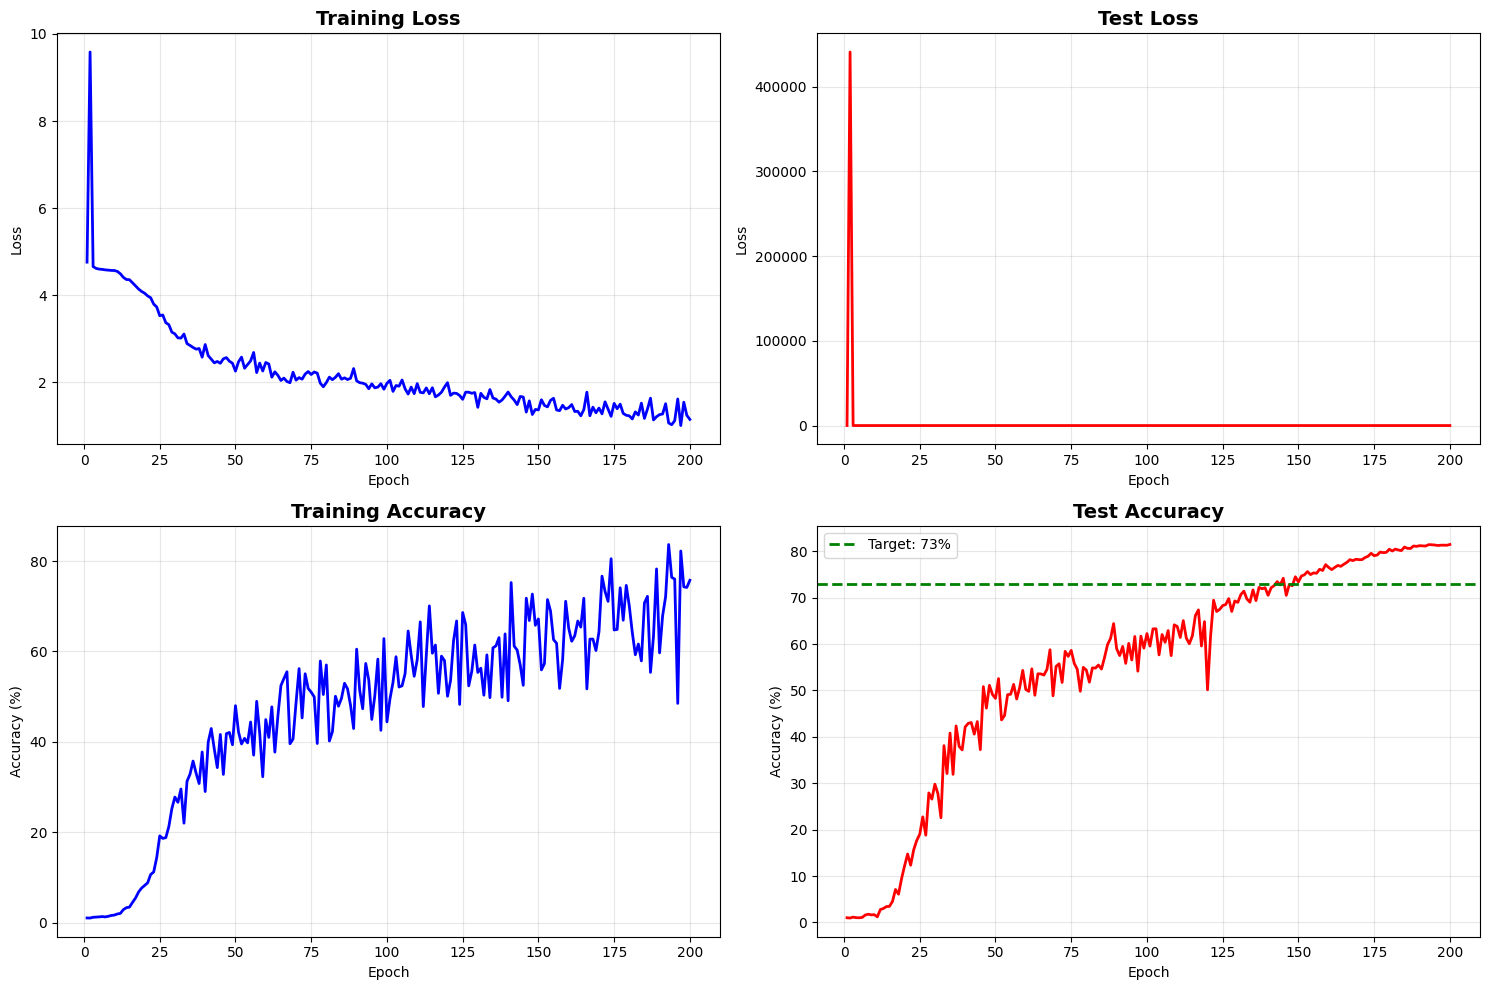

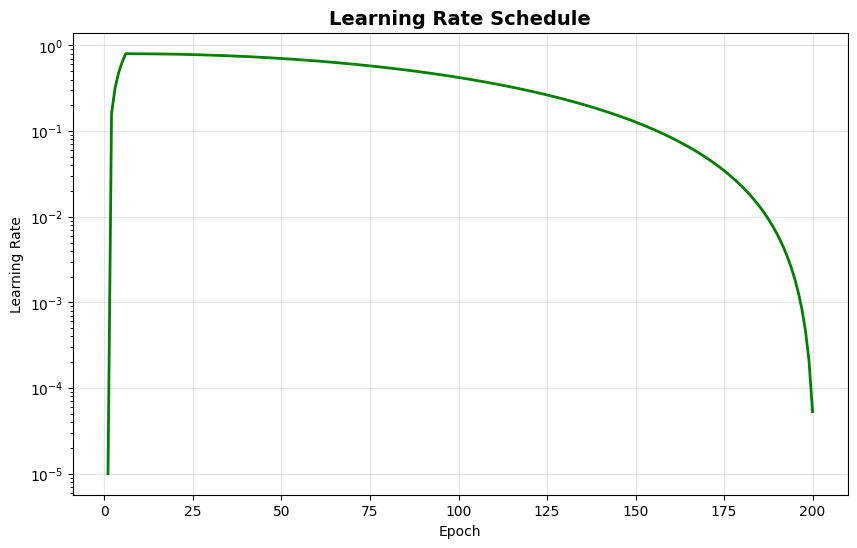


✓ Training curves saved!
  - resnet50_training_curves.png
  - resnet50_lr_schedule.png
  - checkpoints/resnet50_cifar100_best.pth


In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(train_losses) + 1)

# Training loss
axs[0, 0].plot(epochs_range, train_losses, 'b-', linewidth=2)
axs[0, 0].set_title("Training Loss", fontsize=14, fontweight='bold')
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True, alpha=0.3)

# Training accuracy
axs[1, 0].plot(epochs_range, train_acc, 'b-', linewidth=2)
axs[1, 0].set_title("Training Accuracy", fontsize=14, fontweight='bold')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)

# Test loss
axs[0, 1].plot(epochs_range, test_losses, 'r-', linewidth=2)
axs[0, 1].set_title("Test Loss", fontsize=14, fontweight='bold')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True, alpha=0.3)

# Test accuracy
axs[1, 1].plot(epochs_range, test_acc, 'r-', linewidth=2)
axs[1, 1].axhline(y=73, color='g', linestyle='--', linewidth=2, label='Target: 73%')
axs[1, 1].set_title("Test Accuracy", fontsize=14, fontweight='bold')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_curves.png', dpi=300)
plt.show()

# Learning rate
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, learning_rates, 'g-', linewidth=2)
plt.title("Learning Rate Schedule", fontsize=14, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.savefig('resnet50_lr_schedule.png', dpi=300)
plt.show()

print("\n✓ Training curves saved!")
print("  - resnet50_training_curves.png")
print("  - resnet50_lr_schedule.png")
print("  - checkpoints/resnet50_cifar100_best.pth")
